# 2×2の分割表の独立性に関する一様最強力不偏検定の実装例

* 黒木玄
* 2021-12-24, 2023-08-13

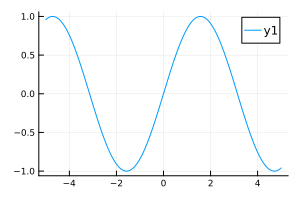

In [1]:
ENV["COLUMNS"] = 200

using Distributions

using StatsPlots
default(fmt=:png, size=(400, 300), titlefontsize=10, tickfontsize=6)

using SymPy
# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " * sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " * sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&") for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

using Memoization

using BenchmarkTools

x ⪅ y = x < y || x ≈ y    # \lessapprox
x ⪆ y = y ⪅ x             # \gtrapprox
x ⪉ y = x < y && !(x ≈ y) # \lnapprox
x ⪊ y = y ⪉ x             # \gnapprox

safemul(x, y) = x == 0 ? zero(float(typeof(x))) : x * y
safediv(x, y) = x == 0 ? zero(float(typeof(x))) : x / y

plot(sin; size=(300, 200))

## 2×2の分割表の独立性検定

### 2つの独立な二項分布モデルの場合を考える

In [2]:
pdfbin(r, s, p, q, x, y) = pdf(Binomial(r, p), x) * pdf(Binomial(s, q), y)
supportbin(r, s) = Iterators.product(0:r, 0:s)
prob_rejection(testfunc, α, r, s, p, q) = 
    sum(pdfbin(r, s, p, q, a, c) * testfunc(a, r-a, c, s-c; α) for (a, c) in supportbin(r, s))

prob_rejection (generic function with 1 method)

### 独立性のχ²検定

In [3]:
function chisqstat(a, b, c, d)
    s, f, m ,n = a + b, c + d, a + c, b + d
    safediv((a*d - b*c)^2 * (m + n), s * f * m * n)
end
chisqstat(A) = chisqstat(A...)

@syms a b c d
chisqstat(a, b, c, d)

             2                 
  (a*d - b*c) *(a + b + c + d) 
-------------------------------
(a + b)*(a + c)*(b + d)*(c + d)

In [4]:
@memoize pval_chisq(a, b, c, d) = ccdf(Chisq(1), chisqstat(a, b, c, d))
pval_chisq(A) = pval_chisq(A...)

test_chisq(a, b, c, d; α = 0.05) = float(pval_chisq(a, b, c, d) < α)
test_chisq(A; α = 0.05) = test_chisq(A...; α)

test_chisq (generic function with 2 methods)

In [5]:
a, b, c, d = 1, 3, 6, 1
pval_chisq(a, b, c, d), test_chisq(a, b, c, d)

(0.04404471164725355, 1.0)

### Fisher検定

In [6]:
@memoize function pval_fisher(a, b, c, d)
    s, f, m ,n = a + b, c + d, a + c, b + d
    (s == 0 || f == 0 || m == 0 || n == 0) && return 1.0
    hg = Hypergeometric(s, f, m)
    p = sum(pdf(hg, j) for j in support(hg) if pdf(hg, j) ⪅ pdf(hg, a))
    min(1, p)
end
pval_fisher(A) = pval_fisher(A...)

test_fisher(a, b, c, d; α = 0.05) = float(pval_fisher(a, b, c, d) < α)
test_fisher(A; α = 0.05) = test_fisher(A...; α)

test_fisher (generic function with 2 methods)

In [7]:
a, b, c, d = 1, 3, 9, 1
pval_fisher(a, b, c, d), test_fisher(a, b, c, d)

(0.04095904095904101, 1.0)

In [8]:
α = 0.05
r, s, p, q = 10, 20, 0.5, 0.5
prob_rejection(test_chisq, α, r, s, p, q), prob_rejection(test_fisher, α, r, s, p, q)

(0.05203096754848962, 0.025631520897150064)

### 独立性の一様最強力不偏検定

In [9]:
function _pvals_umpu(dist, x)
    px = pdf(dist, x)
    P1 = sum(pdf(dist, j) for j in support(dist) if pdf(dist, j) ⪅ px; init = 0.0)
    P0 = sum(pdf(dist, j) for j in support(dist) if pdf(dist, j) ⪉ px; init = 0.0)
    min(1, P0), min(1, P1)
end

function _test_umpu(dist, x; α = 0.05)
    px = pdf(dist, x)
    P1 = sum(pdf(dist, j) for j in support(dist) if pdf(dist, j) ⪅ px; init = 0.0)
    P1 ⪉ α && return 1.0
    P0 = sum(pdf(dist, j) for j in support(dist) if pdf(dist, j) ⪉ px; init = 0.0)
    P0 ⪉ α ? (α - P0) / (P1 - P0) : 0.0
end

@memoize function pvals_umpu(a, b, c, d)
    s, f, m ,n = a + b, c + d, a + c, b + d
    hg = Hypergeometric(s, f, m)
    _pvals_umpu(hg, a)
end
pvals_umpu(A) = pvals_umpu(A...)

@memoize function test_umpu(a, b, c, d; α = 0.05)
    s, f, m ,n = a + b, c + d, a + c, b + d
    hg = Hypergeometric(s, f, m)
    _test_umpu(hg, a; α)
end
test_umpu(A; α = 0.05) = test_umpu(A...; α)

test_umpu (generic function with 2 methods)

In [10]:
α = 0.05
r, s, p, q = 5, 5, 0.4, 0.4
prob_rejection(test_umpu, α, r, s, p, q)

0.05000000000000006

In [11]:
[(a, r-a, c, s-c) for (a, c) in supportbin(r, s)]

6×6 Matrix{NTuple{4, Int64}}:
 (0, 5, 0, 5)  (0, 5, 1, 4)  (0, 5, 2, 3)  (0, 5, 3, 2)  (0, 5, 4, 1)  (0, 5, 5, 0)
 (1, 4, 0, 5)  (1, 4, 1, 4)  (1, 4, 2, 3)  (1, 4, 3, 2)  (1, 4, 4, 1)  (1, 4, 5, 0)
 (2, 3, 0, 5)  (2, 3, 1, 4)  (2, 3, 2, 3)  (2, 3, 3, 2)  (2, 3, 4, 1)  (2, 3, 5, 0)
 (3, 2, 0, 5)  (3, 2, 1, 4)  (3, 2, 2, 3)  (3, 2, 3, 2)  (3, 2, 4, 1)  (3, 2, 5, 0)
 (4, 1, 0, 5)  (4, 1, 1, 4)  (4, 1, 2, 3)  (4, 1, 3, 2)  (4, 1, 4, 1)  (4, 1, 5, 0)
 (5, 0, 0, 5)  (5, 0, 1, 4)  (5, 0, 2, 3)  (5, 0, 3, 2)  (5, 0, 4, 1)  (5, 0, 5, 0)

In [12]:
[pdfbin(r, s, p, q, a, c) for (a, c) in supportbin(r, s)]

6×6 Matrix{Float64}:
 0.00604662   0.0201554   0.0268739   0.0179159  0.00597197   0.000796262
 0.0201554    0.0671846   0.0895795   0.0597197  0.0199066    0.00265421
 0.0268739    0.0895795   0.119439    0.0796262  0.0265421    0.00353894
 0.0179159    0.0597197   0.0796262   0.0530842  0.0176947    0.0023593
 0.00597197   0.0199066   0.0265421   0.0176947  0.00589824   0.000786432
 0.000796262  0.00265421  0.00353894  0.0023593  0.000786432  0.000104858

In [13]:
[test_umpu(a, r-a, c, s-c; α) for (a, c) in supportbin(r, s)]

6×6 Matrix{Float64}:
 0.05    0.05   0.1125  0.3     1.0    1.0
 0.05    0.0    0.0     0.005   0.212  1.0
 0.1125  0.0    0.0     0.0     0.005  0.3
 0.3     0.005  0.0     0.0     0.0    0.1125
 1.0     0.212  0.005   0.0     0.0    0.05
 1.0     1.0    0.3     0.1125  0.05   0.05

In [14]:
[pdfbin(r, s, p, q, a, c) * test_umpu(a, r-a, c, s-c; α) for (a, c) in supportbin(r, s)]

6×6 Matrix{Float64}:
 0.000302331  0.00100777   0.00302331  0.00537477   0.00597197  0.000796262
 0.00100777   0.0          0.0         0.000298598  0.00422019  0.00265421
 0.00302331   0.0          0.0         0.0          0.00013271  0.00106168
 0.00537477   0.000298598  0.0         0.0          0.0         0.000265421
 0.00597197   0.00422019   0.00013271  0.0          0.0         3.93216e-5
 0.000796262  0.00265421   0.00106168  0.000265421  3.93216e-5  5.24288e-6

In [15]:
α, r, s = 0.1, 5, 10
p = q = 0:0.1:1
prob_rejection.(test_umpu, α, r, s, p', q)

11×11 Matrix{Float64}:
 0.1        0.238924   0.418368   0.596632  0.748576  0.8625    0.937024  0.977968  0.995232   0.999676   1.0
 0.0403132  0.1        0.200023   0.32237   0.453657  0.584088  0.706403  0.814845  0.904105   0.968287   0.999858
 0.0598153  0.0644031  0.1        0.16162   0.246538  0.352771  0.477552  0.61581   0.758644   0.891806   0.994174
 0.184603   0.121483   0.0946521  0.1       0.13643   0.204396  0.304435  0.435707  0.594527   0.772905   0.957079
 0.404319   0.256857   0.162409   0.111843  0.1       0.12488   0.186828  0.287714  0.430118   0.616516   0.848461
 0.651758   0.435294   0.280802   0.17788   0.119098  0.1       0.119098  0.17788   0.280802   0.435294   0.651758
 0.848461   0.616516   0.430118   0.287714  0.186828  0.12488   0.1       0.111843  0.162409   0.256857   0.404319
 0.957079   0.772905   0.594527   0.435707  0.304435  0.204396  0.13643   0.1       0.0946521  0.121483   0.184603
 0.994174   0.891806   0.758644   0.61581   0.477552  0.352771

In [16]:
prob_rejection.(test_fisher, α, r, s, p', q)

11×11 Matrix{Float64}:
 0.0          0.08146    0.26272    0.47178    0.66304    0.8125     0.91296    0.96922    0.99328    0.99954    1.0
 0.000146903  0.0318963  0.115416   0.233834   0.371745   0.515479   0.653372   0.77603    0.8766     0.951034   0.998365
 0.00636938   0.0149732  0.047999   0.105532   0.186171   0.287339   0.405587   0.536904   0.677027   0.821744   0.967207
 0.047349     0.0319407  0.0323479  0.0499661  0.0864071  0.143625   0.224044   0.330683   0.467286   0.638446   0.849732
 0.166239     0.103217   0.064743   0.0471802  0.0488187  0.0699728  0.113075   0.182772   0.28602    0.432177   0.633103
 0.376953     0.241505   0.149391   0.0906846  0.0582969  0.0479736  0.0582969  0.0906846  0.149391   0.241505   0.376953
 0.633103     0.432177   0.28602    0.182772   0.113075   0.0699728  0.0488187  0.0471802  0.064743   0.103217   0.166239
 0.849732     0.638446   0.467286   0.330683   0.224044   0.143625   0.0864071  0.0499661  0.0323479  0.0319407  0.047349
 0.967

In [17]:
prob_rejection.(test_chisq, α, r, s, p', q)

11×11 Matrix{Float64}:
 0.0        0.08146    0.26272    0.47178   0.66304   0.8125    0.91296   0.96922   0.99328    0.99954    1.0
 0.0127952  0.0393937  0.119932   0.237594  0.377155  0.524895  0.668506  0.797006  0.900646   0.970823   0.999991
 0.120874   0.0829359  0.0871407  0.130845  0.211068  0.323495  0.461486  0.615079  0.769995   0.906645   0.999136
 0.350389   0.213957   0.137088   0.112044  0.134227  0.200558  0.307861  0.451248  0.622503   0.808464   0.989408
 0.617719   0.383843   0.231555   0.145209  0.114641  0.134064  0.200957  0.314963  0.476777   0.687041   0.945238
 0.828125   0.546418   0.346125   0.213137  0.137375  0.112793  0.137375  0.213137  0.346125   0.546418   0.828125
 0.945238   0.687041   0.476777   0.314963  0.200957  0.134064  0.114641  0.145209  0.231555   0.383843   0.617719
 0.989408   0.808464   0.622503   0.451248  0.307861  0.200558  0.134227  0.112044  0.137088   0.213957   0.350389
 0.999136   0.906645   0.769995   0.615079  0.461486  0.323495

### 独立性の検定における第一種の過誤の確率のプロット

In [18]:
function plot_realalphas(; r = 10, s = 20, p = 0.4, q = p, kwargs...)
    α = 0:0.005:1
    xtick = ytick = 0:0.1:1
    A = prob_rejection.(test_chisq, α, r, s, p, q)
    B = prob_rejection.(test_fisher, α, r, s, p, q)
    C = prob_rejection.(test_umpu, α, r, s, p, q)    
    P = plot(; legend=:topleft, xtick, ytick)
    plot!(α, A; label="chisq")
    plot!(α, B; label="fisher", ls=:dash)
    plot!(α, C; label="umpu", ls=:dashdot)
    
    α = 0:0.0005:0.1
    xtick = ytick = 0:0.01:1
    A = prob_rejection.(test_chisq, α, r, s, p, q)
    B = prob_rejection.(test_fisher, α, r, s, p, q)
    C = prob_rejection.(test_umpu, α, r, s, p, q)    
    Q = plot(; legend=:topleft, xtick, ytick)
    plot!(α, A; label="chisq")
    plot!(α, B; label="fisher", ls=:dash)
    plot!(α, C; label="umpu", ls=:dashdot)
    
    plot(P, Q; size=(600, 300), layout=(1, 2))
    plot!(; kwargs...)
end

plot_realalphas (generic function with 1 method)

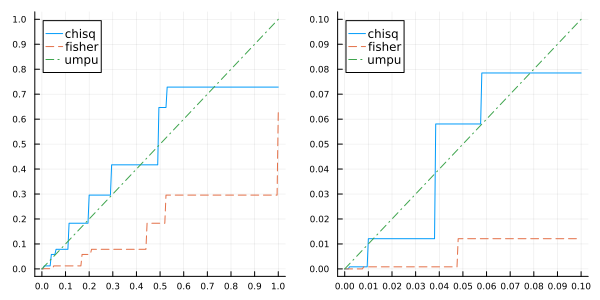

In [19]:
plot_realalphas(; r=5, s=5, p=0.3)

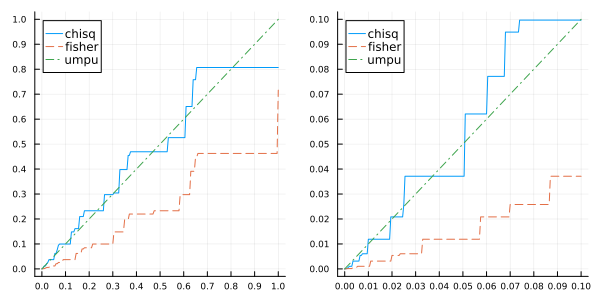

In [20]:
plot_realalphas(; r=10, s=10, p=0.3)

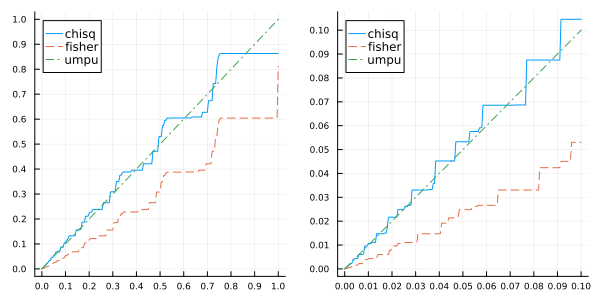

In [21]:
plot_realalphas(; r=20, s=20, p=0.3)

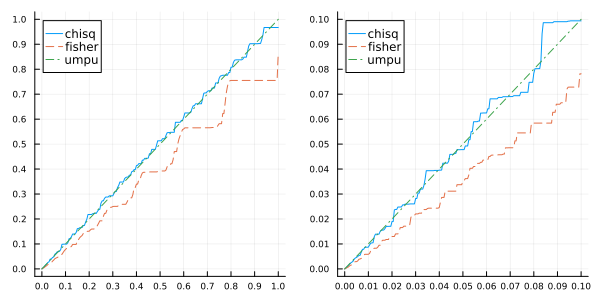

In [22]:
plot_realalphas(; r=20, s=50, p=0.3)

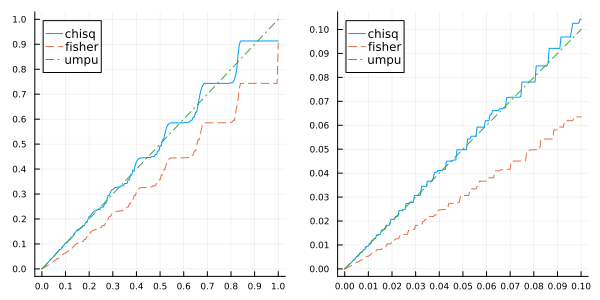

In [23]:
plot_realalphas(; r=50, s=50, p=0.3)

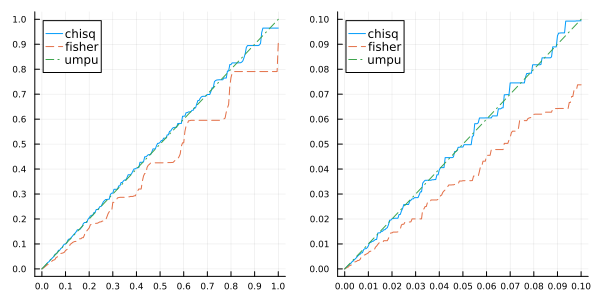

In [24]:
plot_realalphas(; r=20, s=100, p=0.3)

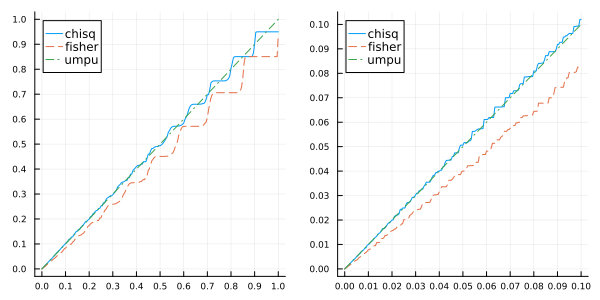

In [25]:
plot_realalphas(; r=50, s=100, p=0.3)

### 独立性の検定における検出力のプロット

In [26]:
function plot_powers(; α = 0.05, r = 10, s = 20,
        levels = [0.0:0.4α:2α; 0.2:0.2:1], kwargs...)
    p = q = 0:0.01:1
    xtick = ytick = 0:0.1:1
    
    C = prob_rejection.(test_umpu, α, r, s, p', q)
    A = prob_rejection.(test_chisq, α, r, s, p', q)
    B = prob_rejection.(test_fisher, α, r, s, p', q)
    
    R = contour(p, q, C; clim=(0, 1), title="power of umpu", levels, xtick, ytick)
    P = contour(p, q, A; clim=(0, 1), title="power of chisq", levels, xtick, ytick)
    Q = contour(p, q, B; clim=(0, 1), title="power of fisher", levels, xtick, ytick)
    
    AC = @. log2(C) - log2(A)
    AB = @. log2(B) - log2(A)
    CB = @. log2(B) - log2(C)
    
    PR = heatmap(p, q, AC; clim=(-1, 1), c=:bwr, title="power: chisq b-w-r umpu", xtick, ytick)
    PQ = heatmap(p, q, AB; clim=(-1, 1), c=:bwr, title="power: chisq b-w-r fisher", xtick, ytick)
    RQ = heatmap(p, q, CB; clim=(-1, 1), c=:bwr, title="power: umpu b-w-r fisher", xtick, ytick)

    plot(R, P, Q, PR, PQ, RQ; size=(800, 560), layout=(2, 3),
        colorbar=false, contour_labels=true)
    plot!(; kwargs...)
end

plot_powers (generic function with 1 method)

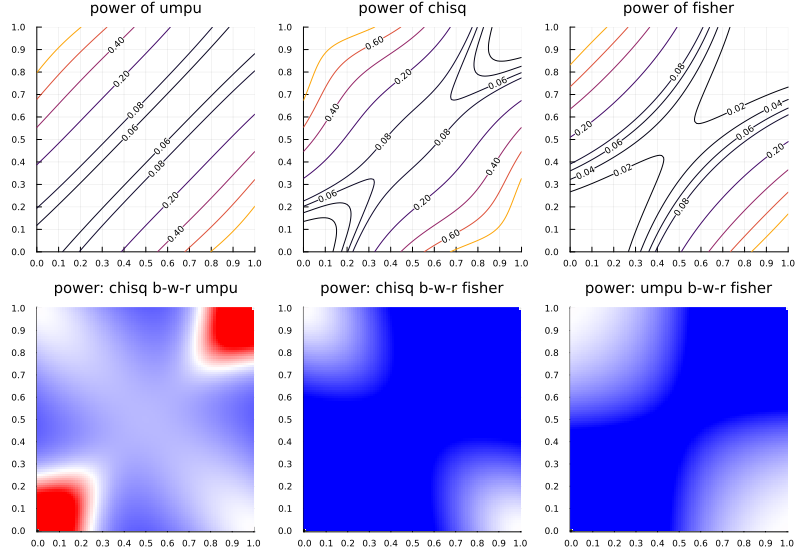

In [27]:
plot_powers(; r = 5, s = 5)

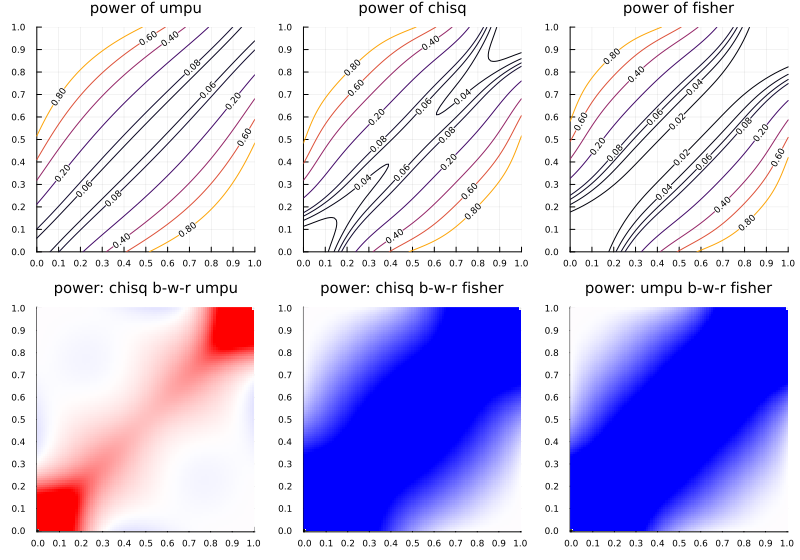

In [28]:
plot_powers(; r = 10, s = 10)

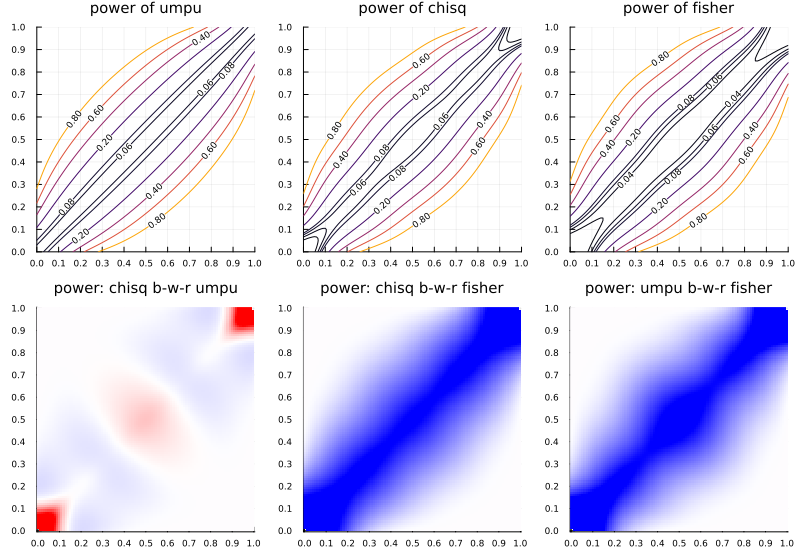

In [29]:
plot_powers(; r = 20, s = 20)

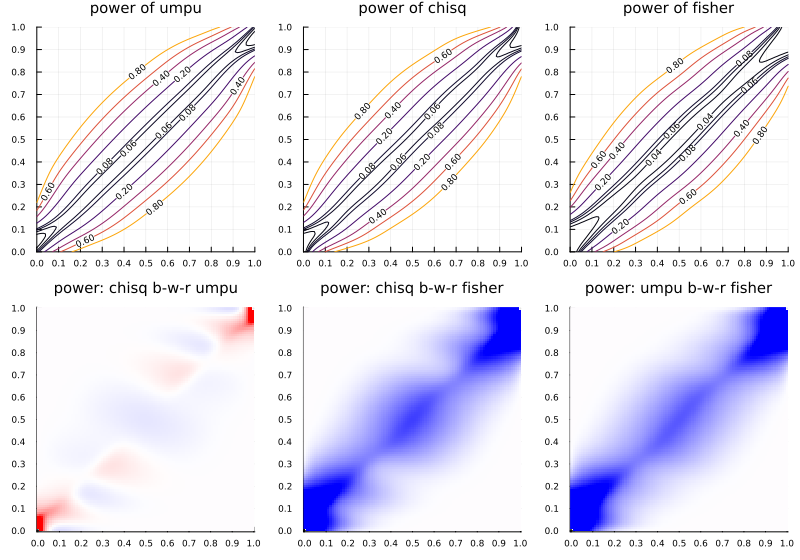

In [30]:
plot_powers(; r = 20, s = 50)

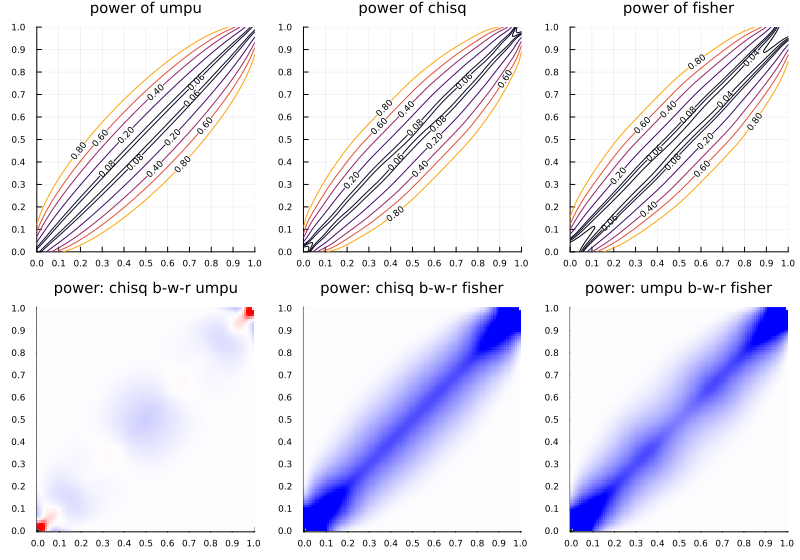

In [31]:
plot_powers(; r = 50, s = 50)

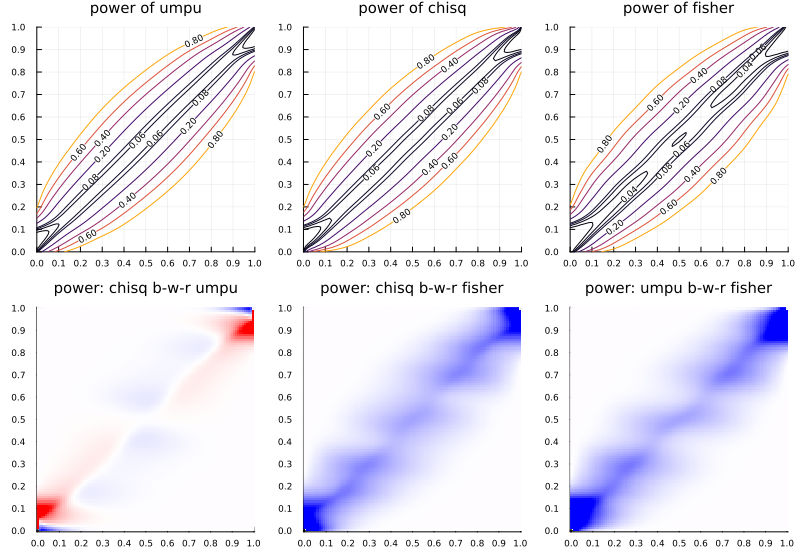

In [32]:
plot_powers(; r = 20, s = 100)

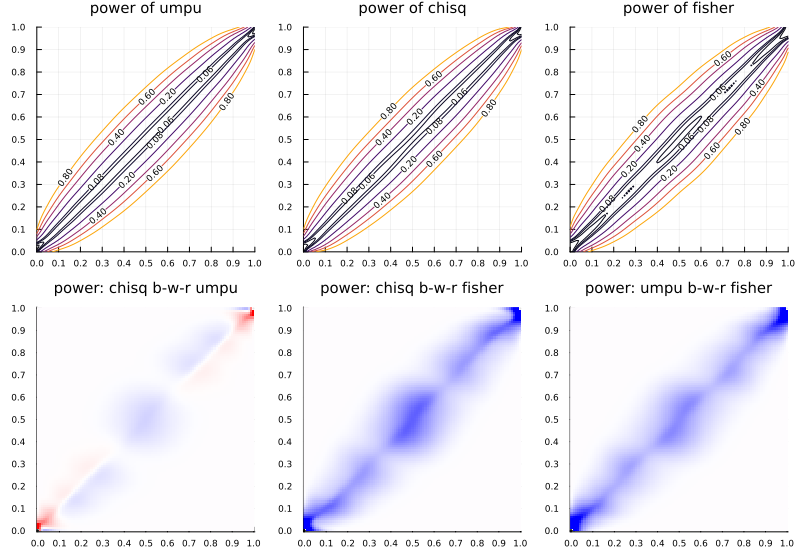

In [33]:
plot_powers(; r = 50, s = 100)